In [1]:
# Imports
import requests
import json
import pandas as pd
import numpy as np

In [2]:
# Pandas Options
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_rows", 300)

In [3]:
# Billing Status
from Helper import StakingRewardsAPIClient

client = StakingRewardsAPIClient()
status = client.get_billing_status()
print(status)

{'plan_name': 'startup yearly v0', 'available_credits': 1336536, 'monthly_quota': 1500000, 'subscribed_at': '2025-11-24T07:32:41Z', 'requests_allowed': True, 'billing_date': '2026-02-18T13:27:47.137364Z'}


In [4]:
# List all available assets
MIN_MARKET_CAP = 1_000_000_000  # e.g. $1B

metrics_col = [
    "marketcap",
    "price",
    "active_validators",
    "real_reward_rate",
    "reward_rate",
    "staked_tokens",
    "staking_ratio",
    "total_staking_wallets",
    "total_validators"
]

metric_keys_str = ", ".join(f'"{m}"' for m in metrics_col)

query = f"""
{{
  assets(limit: 150) {{
    slug
    id
    metrics(
      where: {{ metricKeys: [{metric_keys_str}] }},
      limit: {len(metrics_col)}
    ) {{
      metricKey
      label
      defaultValue
    }}
  }}
}}
"""
result = client.execute_raw_query(query)

assets = result["data"]["assets"]

rows = []

for asset in assets:
    # metrics can be None -> normalize to []
    metrics_list = asset.get("metrics") or []

    # extra safety in case the API returns something unexpected
    if not isinstance(metrics_list, list):
        metrics_list = []

    metric_map = {}
    for m in metrics_list:
        if not isinstance(m, dict):
            continue
        key = m.get("metricKey")
        if not key:
            continue
        metric_map[key] = m.get("defaultValue")

    row = {"asset": asset.get("slug")}
    for k in metrics_col:
        # if a metric isn't available, this becomes None/NaN in pandas (fine)
        row[k] = metric_map.get(k)

    rows.append(row)

df = pd.DataFrame(rows)
df = df.sort_values("marketcap", ascending=False)

column_order = ["asset"] + metrics_col
df = df.reindex(columns=column_order)
filtered_df = df[
    (df["marketcap"] >= 500_000_000) &
    (df["active_validators"] > 10)
]

filtered_df.head()
filtered_df.describe()
filtered_df.set_index("asset")

#assets = 
#ethereum-2-0
#solana
#cardano
#avalanche
#polkadot
#cosmos
#near-protocol
#tezos
#aptos
#sui

,marketcap,price,active_validators,real_reward_rate,reward_rate,staked_tokens,staking_ratio,total_staking_wallets,total_validators
asset,,,,,,,,,
ethereum-2-0,"356,602,165,209.79","2,954.18","942,851.00",2.00,2.89,"36,411,772.39",30.17,"942,851.00","976,484.00"
binance-smart-chain,"120,881,321,803.40",886.34,45.00,7.38,3.01,"25,171,282.44",18.46,"12,486.00",45.00
solana,"71,761,536,995.03",126.83,787.00,1.56,6.11,"426,371,063.90",68.89,"1,208,814.00","6,770.00"
tron,"27,996,583,047.34",0.30,27.00,NaN,3.26,"43,899,857,207.00",46.35,"314,036.00",432.00
staked-ether,"27,675,276,301.77","2,953.74","252,074.00",1.56,2.43,"9,372,167.52",NaN,"584,046.00","252,074.17"
cardano,"13,170,129,622.18",0.36,979.00,0.67,2.37,"21,451,800,102.85",57.84,"1,277,697.00","2,907.00"
sui,"5,620,260,048.93",1.48,125.00,-1.62,1.72,"7,479,925,804.48",74.80,0.00,125.00
avalanche,"5,190,257,721.73",12.04,764.00,3.35,7.01,"218,059,184.33",46.61,"54,957.00",764.00
hedera-hashgraph,"4,623,250,215.58",0.11,32.00,2.12,2.50,"15,967,871,966.00",31.94,"122,742.00",32.00


In [5]:
# Reward options for assets token

def build_staking_type_availability_table(asset_slugs: list[str]) -> pd.DataFrame:
    """
    Build a dataframe showing which staking types are available per asset.

    Args:
        asset_slugs: List of asset slugs

    Returns:
        Pandas DataFrame with asset as first column and staking types as columns
    """
    rows = []
    all_types = set()

    # First pass: collect available types per asset
    asset_to_types = {}

    for asset in asset_slugs:
        types = client.discover_reward_option_types(asset)
        keys = {t["key"] for t in types if "key" in t}
        asset_to_types[asset] = keys
        all_types.update(keys)

    # Sort staking types for stable column order
    sorted_types = sorted(all_types)

    # Second pass: build rows
    for asset in asset_slugs:
        row = {"asset": asset}
        asset_types = asset_to_types.get(asset, set())

        for t in sorted_types:
            row[t] = "✓" if t in asset_types else ""

        rows.append(row)

    df = pd.DataFrame(rows)
    return df

staking_types = build_staking_type_availability_table(filtered_df['asset'].astype(str).tolist())
display(staking_types)

,asset,actively-validated-service,custodial,hosting,lending,liquid-staking,operator,partial-staking,pos,smart-contract,solo-staking
0,ethereum-2-0,✓,✓,✓,✓,✓,✓,✓,,✓,✓
1,binance-smart-chain,,✓,,,,,,✓,,✓
2,solana,,✓,,,✓,,,✓,,
3,tron,,✓,✓,,,,,✓,,✓
4,staked-ether,✓,,,,,,,,✓,
5,cardano,,,,,,,,✓,,
6,sui,,✓,,,✓,,,✓,,✓
7,avalanche,,✓,✓,,✓,,,✓,✓,
8,hedera-hashgraph,,,,,,,,✓,✓,✓
9,crypto-com-coin,,,✓,,,,,✓,,✓


In [6]:
# Staked tokens by type for assets

def _extract_rows(resp):
    """
    Normalize common API response shapes into a list of row dicts.
    Supports: list[...] or dict{"data": [...]} or dict{"results":[...]} etc.
    """
    if resp is None:
        return []
    if isinstance(resp, list):
        return resp
    if isinstance(resp, dict):
        for k in ("data", "results", "items"):
            if k in resp and isinstance(resp[k], list):
                return resp[k]
    return []

def build_provider_stake_shares_table(
    asset_slugs: list[str],
    client,
    limit: int = 200,
    is_active: bool = True,
    include_reward_rate: bool = True,
    use_cache: bool = True,
    cell_metric: str = "total_staked_tokens",
    show_percentages: bool = False
) -> pd.DataFrame:
    """
    Build a dataframe with assets as rows, type_keys as columns, numeric cell values per (asset, type),
    plus a final 'total' column.

    cell_metric:
      - "provider_count": number of providers returned by get_provider_stake_shares
      - "total_staked_tokens": sum of stake-share-like fields if present (fallback to provider_count)
    """
    # 1) Discover supported types per asset (same idea as your availability table)
    asset_to_types: dict[str, set[str]] = {}
    all_types: set[str] = set()

    for asset in asset_slugs:
        types = client.discover_reward_option_types(asset)
        keys = {t.get("key") for t in (types or []) if isinstance(t, dict) and t.get("key")}
        asset_to_types[asset] = set(keys)
        all_types.update(keys)

    sorted_types = sorted(all_types)

    # 2) Build numeric table by calling get_provider_stake_shares per supported (asset, type)
    rows = []
    for asset in asset_slugs:
        supported = asset_to_types.get(asset, set())
        row = {"asset": asset}

        total = 0
        for t in sorted_types:
            if t not in supported:
                row[t] = "not supported"
                continue

            try:
                resp = client.get_provider_stake_shares(
                    asset_slug=asset,
                    limit=limit,
                    is_active=is_active,
                    include_reward_rate=include_reward_rate,
                    use_cache=use_cache,
                    type_keys=[t],  # pass the single type key
                )
            except Exception as e:
                # If the API errors for a supported type, capture a readable marker
                row[t] = f"error: {type(e).__name__}"
                continue

            if cell_metric == "provider_count":
                numeric_vals = []
                for t in sorted_types:
                    v = row.get(t)
                    if isinstance(v, (int, float, np.integer, np.floating)):
                        numeric_vals.append(float(v))
                total = float(np.sum(numeric_vals)) if numeric_vals else 0.0
                no_of_providers = len(resp['providers'])
                if show_percentages:
                    if total > 0:
                        row[t] = no_of_providers / total
                    else:
                        row[t] = 0
                else:
                    row[t] = no_of_providers


            elif cell_metric == "total_staked_tokens":
                sum_of_staked = sum(
                    p.get("staked_tokens", 0)
                    for p in resp.get("providers", [])
                    if p.get("staked_tokens") is not None
                )
                total = resp['total_staked_tokens']
                if show_percentages:
                    if total > 0:
                        row[t] = sum_of_staked / total
                    else:
                        row[t] = 0
                else:
                    row[t] = sum_of_staked
            else:
                raise ValueError("cell_metric must be 'provider_count' or 'stake_share_sum'")

        row['total'] = total
        rows.append(row)

    df = pd.DataFrame(rows)
    return df

# Example usage:
asset_slugs = filtered_df["asset"].astype(str).tolist()
stake_shares_table = build_provider_stake_shares_table(
    asset_slugs=asset_slugs,
    client=client,
    cell_metric="total_staked_tokens",
    show_percentages=True
)
display(stake_shares_table)

,asset,actively-validated-service,custodial,hosting,lending,liquid-staking,operator,partial-staking,pos,smart-contract,solo-staking,total
0,ethereum-2-0,0.01,0.00,0.09,0.00,0.52,0.26,0.00,not supported,0.91,0.00,"35,694,110.51"
1,binance-smart-chain,not supported,0.00,not supported,not supported,not supported,not supported,not supported,0.99,not supported,0.00,"25,429,674.82"
2,solana,not supported,0.00,not supported,not supported,0.07,not supported,not supported,0.37,not supported,not supported,"413,847,099.60"
3,tron,not supported,0.00,0.00,not supported,not supported,not supported,not supported,0.99,not supported,0.00,"43,312,913,874.00"
4,staked-ether,0.05,not supported,not supported,not supported,not supported,not supported,not supported,not supported,0.00,not supported,"9,381,594.66"
5,cardano,not supported,not supported,not supported,not supported,not supported,not supported,not supported,0.66,not supported,not supported,"21,019,816,840.54"
6,sui,not supported,0.00,not supported,not supported,0.00,not supported,not supported,1.00,not supported,0.00,"7,478,759,383.25"
7,avalanche,not supported,0.00,0.09,not supported,0.12,not supported,not supported,0.12,0.00,not supported,"208,570,455.99"
8,hedera-hashgraph,not supported,not supported,not supported,not supported,not supported,not supported,not supported,0.87,0.03,0.00,"15,960,108,102.00"
9,crypto-com-coin,not supported,not supported,0.00,not supported,not supported,not supported,not supported,1.02,not supported,0.00,"12,138,290,918.84"


In [7]:
def calculate_hhi_from_values(providers: list[dict], total_value: float) -> float:
    """
    Calculate the Herfindahl–Hirschman Index (HHI) from absolute values.

    Args:
        providers: List of dicts (e.g. staking providers or categories)
        total_value: Total staking amount for the network

    Returns:
        HHI value in the range [0, 1]
    """
    provider_value_key = 'staked_tokens'
    if total_value <= 0:
        return 0.0

    tracked_total = 0.0
    hhi = 0.0

    for p in providers:
        value = p.get(provider_value_key)
        if value is None or value <= 0:
            continue

        tracked_total += value
        share = value / total_value
        hhi += share ** 2

    # residual / untracked stake
    residual = total_value - tracked_total
    if residual > 0:
        residual_share = residual / total_value
        hhi += residual_share ** 2

    return hhi

def calculate_hhi_from_staking_shares_response(response: dict):
    return calculate_hhi_from_values(response['providers'], response['total_staked_tokens'])

In [8]:
# correct to use only correct types
for asset in filtered_df['asset']:
    resp = client.get_provider_stake_shares(asset_slug=asset, limit=300, is_active=True, include_reward_rate=True)
    result = calculate_hhi_from_staking_shares_response(resp)
    print(f'Asset: {asset} HHI: {result}')

Asset: ethereum-2-0 HHI: 0.9183742994606167
Asset: binance-smart-chain HHI: 0.03464507389768454
Asset: solana HHI: 0.314227028818143
Asset: tron HHI: 0.04835389072174874
Asset: staked-ether HHI: 0.8972338644642671
Asset: cardano HHI: 0.05755100696310372
Asset: sui HHI: 0.011724497532668876
Asset: avalanche HHI: 0.4520324854001061
Asset: hedera-hashgraph HHI: 0.03437835097241684
Asset: crypto-com-coin HHI: 0.13568135697072445
Asset: polkadot HHI: 0.11324139748546201
Asset: near-protocol HHI: 0.02388106092709307
Asset: aptos HHI: 0.5369060388543946
Asset: cosmos HHI: 0.056050531566813014
Asset: tezos HHI: 0.10969824388449166
Asset: fetch-ai HHI: 0.07840996756403498


In [9]:
def calculate_nakamoto_coefficient(
    providers: list[dict],
    total_value: float,
    threshold: float = 0.33
) -> int | None:
    """
    Calculate the Nakamoto coefficient given partial provider coverage.

    Args:
        providers: List of provider dicts
        total_value: Total network stake
        threshold: Control threshold (e.g. 0.33 or 0.50)

    Returns:
        Nakamoto coefficient (int), or None if not computable
    """
    provider_value_key = 'staked_tokens'
    if total_value <= 0:
        return None

    stakes = []

    tracked_total = 0.0
    for p in providers:
        value = p.get(provider_value_key)
        if value is None or value <= 0:
            continue
        stakes.append(value)
        tracked_total += value

    # Add residual stake as a single conservative entity
    residual = total_value - tracked_total
    if residual > 0:
        stakes.append(residual)

    # Sort descending
    stakes.sort(reverse=True)

    cumulative = 0.0
    for i, stake in enumerate(stakes, start=1):
        cumulative += stake
        if cumulative / total_value >= threshold:
            return i

    return None

def calculate_nakamoto_coefficient_from_staking_shares_response(response: dict):
    return calculate_nakamoto_coefficient(response['providers'], response['total_staked_tokens'])

In [10]:
# correct to use only correct types
for asset in filtered_df['asset']:
    resp = client.get_provider_stake_shares(asset_slug=asset, limit=300, is_active=True, include_reward_rate=True)
    result = calculate_nakamoto_coefficient_from_staking_shares_response(resp)
    print(f'Asset: {asset} Nakamoto: {result}')

Asset: ethereum-2-0 Nakamoto: 1
Asset: binance-smart-chain Nakamoto: 7
Asset: solana Nakamoto: 1
Asset: tron Nakamoto: 5
Asset: staked-ether Nakamoto: 1
Asset: cardano Nakamoto: 5
Asset: sui Nakamoto: 19
Asset: avalanche Nakamoto: 1
Asset: hedera-hashgraph Nakamoto: 10
Asset: crypto-com-coin Nakamoto: 2
Asset: polkadot Nakamoto: 2
Asset: near-protocol Nakamoto: 8
Asset: aptos Nakamoto: 1
Asset: cosmos Nakamoto: 4
Asset: tezos Nakamoto: 2
Asset: fetch-ai Nakamoto: 3


In [10]:
# top-k stake shares
def calculate_top_k_stake_shares(
    providers: list[dict],
    total_value: float,
    k_values: list[int],
    include_residual_as_single_stake: bool
) -> dict:
    """
    Calculate top-k stake shares relative to total network stake.

    Args:
        providers: List of provider dicts
        total_value: Total network stake
        k_values: List of k values (e.g. [1, 3, 5, 10])
        include_residual_as_single_stake: Whether to treat untracked stake
                                         as a single additional entity

    Returns:
        Dict containing top-k shares and diagnostics
    """
    provider_value_key = 'staked_tokens'
    if total_value <= 0:
        return {
            "top_k": {},
            "tracked_total": 0.0,
            "residual": 0.0,
            "coverage": 0.0,
            "entity_count": 0
        }

    stakes = []
    tracked_total = 0.0

    for p in providers:
        value = p.get(provider_value_key)
        if value is None or value <= 0:
            continue
        value = float(value)
        stakes.append(value)
        tracked_total += value

    residual = max(total_value - tracked_total, 0.0)

    if include_residual_as_single_stake and residual > 0:
        stakes.append(residual)

    stakes.sort(reverse=True)

    top_k = {}
    cumulative = 0.0
    max_k = max(k_values)

    prefix = []
    for s in stakes[:max_k]:
        cumulative += s
        prefix.append(cumulative)

    for k in k_values:
        if k <= 0:
            continue
        if k > len(stakes):
            top_k[str(k)] = sum(stakes) / total_value
        else:
            top_k[str(k)] = prefix[k - 1] / total_value

    return {
        "top_k": top_k,
        "tracked_total": tracked_total,
        "residual": residual,
        "coverage": tracked_total / total_value,
        "entity_count": len(stakes),
        "residual_included_as_single_stake": include_residual_as_single_stake
    }

def calculate_top_k_stake_shares_from_staking_shares_response(response: dict):
    return calculate_top_k_stake_shares(response['providers'], response['total_staked_tokens'], [1, 3, 4], False)

In [11]:
# gini
def calculate_gini_from_values(
    providers: list[dict],
    total_value: float,
    residual_handling: str = "single",
    n_residual_providers: int | None = None,
) -> float:
    """
    Calculate the Gini coefficient from absolute values.

    Args:
        providers: List of dicts (e.g. staking providers or categories)
        total_value: Total staking amount for the network
        residual_handling:
            - "single": treat residual as one provider
            - "ignore": ignore residual entirely
            - "equal_split": split residual across n_residual_providers
        n_residual_providers: Number of hypothetical providers when using
            residual_handling="equal_split"

    Returns:
        Gini coefficient in the range [0, 1]
    """
    provider_value_key = "staked_tokens"

    if total_value <= 0:
        return 0.0

    values: list[float] = []
    tracked_total = 0.0

    for p in providers:
        value = p.get(provider_value_key)
        if value is None or value <= 0:
            continue
        values.append(float(value))
        tracked_total += value

    residual = total_value - tracked_total

    # ----------------------------------
    # Residual handling
    # ----------------------------------
    if residual > 0:
        if residual_handling == "single":
            values.append(residual)

        elif residual_handling == "equal_split":
            if not n_residual_providers or n_residual_providers <= 0:
                raise ValueError(
                    "n_residual_providers must be > 0 when "
                    "residual_handling='equal_split'"
                )
            split_value = residual / n_residual_providers
            values.extend([split_value] * n_residual_providers)

        elif residual_handling == "ignore":
            pass

        else:
            raise ValueError(
                f"Unknown residual_handling mode: {residual_handling}"
            )

    n = len(values)
    if n == 0:
        return 0.0

    values.sort()

    # Gini formula:
    # G = (2 * sum(i * x_i)) / (n * sum(x_i)) - (n + 1) / n
    weighted_sum = 0.0
    for i, v in enumerate(values, start=1):
        weighted_sum += i * v

    gini = (2.0 * weighted_sum) / (n * sum(values)) - (n + 1.0) / n

    # numerical safety
    return max(0.0, min(1.0, gini))

In [33]:
rows = []
provider_asset_rows = []
lorenz_inputs = {}

INCLUDED_BASE_TYPES = {
    "actively-validated-service",
    "hosting",
    "operator",
    "partial-staking",
    "solo-staking",
    "pos",
}

EXCLUDED_TYPES = {
    "custodial",
    "lending",
    "smart-contract",
}

LIQUID_TYPE = "liquid-staking"
MIN_COVERAGE_WITHOUT_LIQUID = 0.70

# NEW FLAG
USE_MAX_PER_PROVIDER = True  # <- set False to keep old behavior

def to_float(x, default=0.0):
    if x is None:
        return default
    try:
        if isinstance(x, str):
            x = x.replace(",", "").strip()
            if x == "":
                return default
        return float(x)
    except (TypeError, ValueError):
        return default


def collapse_providers_max(per_type_rows):
    """
    Collapse provider-role rows into one row per provider with:
      value = max(staked_tokens) across included types for that provider.
    """
    by_provider = {}

    for p in per_type_rows:
        provider_key = p.get("provider")
        if not provider_key:
            continue

        v = to_float(p.get("staked_tokens", 0.0))
        cur = by_provider.get(provider_key)

        if cur is None:
            # keep a representative row; value will be overwritten/updated
            by_provider[provider_key] = {
                **p,
                "value": v,
            }
        else:
            # update value to max
            if v > cur["value"]:
                cur["value"] = v
                # optionally keep the metadata from the max-row (type label etc.)
                # merge/replace the representative row fields:
                for k, val in p.items():
                    cur[k] = val

    return list(by_provider.values())


for asset in filtered_df["asset"]:
    resp = client.get_provider_stake_shares(
        asset_slug=asset,
        limit=300,
        is_active=True,
        include_reward_rate=True
    )

    providers = resp.get("providers", [])
    if not providers:
        continue

    total_value = to_float(resp.get("total_staked_tokens", 0.0))
    if total_value <= 0:
        continue

    providers_clean = [
        p for p in providers
        if p.get("reward_option_type_key") not in EXCLUDED_TYPES
    ]

    non_liquid = [
        p for p in providers_clean
        if (
            p.get("reward_option_type_key") in INCLUDED_BASE_TYPES
            and p.get("reward_option_type_key") != LIQUID_TYPE
        )
    ]

    non_liquid_sum = sum(to_float(p.get("staked_tokens", 0.0)) for p in non_liquid)
    coverage_without_liquid = non_liquid_sum / total_value

    # auto-include liquid if excluding it would leave too little covered stake
    include_liquid = coverage_without_liquid < MIN_COVERAGE_WITHOUT_LIQUID

    included_types = set(INCLUDED_BASE_TYPES)
    if include_liquid:
        included_types.add(LIQUID_TYPE)

    filtered_providers = [
        p for p in providers_clean
        if (
            p.get("reward_option_type_key") in included_types
            and to_float(p.get("staked_tokens", 0.0)) > 0.0
        )
    ]

    # ---- NEW: compute "included_sum" differently depending on flag ----
    if USE_MAX_PER_PROVIDER:
        metric_providers = collapse_providers_max(filtered_providers)
        included_sum = sum(p["value"] for p in metric_providers)
        provider_count = len(metric_providers)
    else:
        metric_providers = [
            {
                **p,
                "value": to_float(p.get("staked_tokens", 0.0)),
            }
            for p in filtered_providers
        ]
        included_sum = sum(p["value"] for p in metric_providers)
        provider_count = len(metric_providers)

    coverage_included = included_sum / total_value

    # ---- metrics ----
    gini = calculate_gini_from_values(metric_providers, total_value)

    nakamoto = calculate_nakamoto_coefficient(
        metric_providers,
        total_value=total_value,
        threshold=0.33,
    )

    hhi = calculate_hhi_from_values(
        metric_providers,
        total_value=total_value,
    )

    topk = calculate_top_k_stake_shares(
        metric_providers,
        total_value=total_value,
        k_values=[1, 3, 5],
        include_residual_as_single_stake=False,
    )

    # lorenz inputs: store the same set you used for metrics
    is_eligible = coverage_included > 0.70 and provider_count > 30
    if is_eligible:
        lorenz_inputs[asset] = {
            "providers": metric_providers,
            "total_value": total_value,
        }
    
        for p in metric_providers:
            provider_asset_rows.append({
                "asset": asset,
                "provider": p.get("provider"),
                "provider_name": p.get("name"),
                "effective_stake": p.get("value"),
                "asset_total_stake": total_value,
                "stake_share_in_asset": p.get("value") / total_value,
            })

    rows.append({
        "asset": asset,
        "coverage_included": coverage_included,
        "provider_count": provider_count,
        "include_liquid": include_liquid,
        "use_max_per_provider": USE_MAX_PER_PROVIDER,  # helpful for debugging runs
        "nakamoto": nakamoto,
        "hhi": hhi,
        "gini": gini,
        "top_1_share": topk.get("top_k", {}).get("1"),
        "top_3_share": topk.get("top_k", {}).get("3"),
        "top_5_share": topk.get("top_k", {}).get("5"),
        "is_eligible_for_analysis": is_eligible
    })

df = pd.DataFrame(rows)
display(df)

,asset,coverage_included,provider_count,include_liquid,use_max_per_provider,nakamoto,hhi,gini,top_1_share,top_3_share,top_5_share,is_eligible_for_analysis
0,ethereum-2-0,0.82,121,True,True,2,0.12,0.86,0.26,0.44,0.52,True
1,binance-smart-chain,1.00,45,False,True,7,0.04,0.43,0.06,0.15,0.24,True
2,solana,0.41,59,True,True,1,0.36,0.83,0.03,0.10,0.16,False
3,tron,0.98,27,False,True,5,0.05,0.29,0.10,0.25,0.37,False
4,staked-ether,0.05,84,True,True,1,0.90,0.98,0.02,0.03,0.03,False
5,cardano,0.74,263,False,True,3,0.07,0.57,0.05,0.10,0.14,True
6,sui,1.00,123,False,True,19,0.01,0.37,0.03,0.08,0.12,True
7,avalanche,0.31,50,True,True,1,0.50,0.90,0.10,0.18,0.21,False
8,hedera-hashgraph,0.87,32,False,True,9,0.04,0.12,0.03,0.08,0.14,True
9,crypto-com-coin,0.94,93,False,True,2,0.12,0.87,0.27,0.46,0.59,True


In [40]:
# Cross asset providers
provider_asset_df = pd.DataFrame(provider_asset_rows)
provider_cross = (
    provider_asset_df
    .groupby("provider")
    .agg(
        provider_name=("provider_name", "first"),
        assets_present=("asset", "nunique"),
        total_effective_stake=("effective_stake", "sum"),
        mean_asset_share=("stake_share_in_asset", "mean"),
        max_asset_share=("stake_share_in_asset", "max"),
    )
    .reset_index()
)
provider_cross = provider_cross[provider_cross["assets_present"] >= 2]
provider_cross = provider_cross[provider_cross["max_asset_share"] >= 0.01]
provider_cross = provider_cross.sort_values(
    ["assets_present", "total_effective_stake"],
    ascending=[False, False]
)
display(provider_cross)

,provider,provider_name,assets_present,total_effective_stake,mean_asset_share,max_asset_share
579,kiln,Kiln,8,"978,696,734.34",0.05,0.17
436,figment-networks,Figment,7,"1,170,683,401.27",0.03,0.08
50,allnodes,Allnodes,7,"270,363,440.06",0.02,0.08
418,everstake,Everstake,6,"580,376,506.79",0.03,0.07
542,infstones,InfStones,6,"176,169,529.79",0.01,0.04
811,p2p-validator,P2P.org,6,"154,629,257.99",0.02,0.03
160,blockdaemon,Blockdaemon,5,"299,765,469.10",0.01,0.02
248,chorus-one,Chorus One,5,"130,646,304.64",0.01,0.02
143,binance-staking,Binance Staking,5,"100,634,061.56",0.05,0.10
289,cosmostation,Cosmostation,5,"99,088,078.72",0.02,0.05


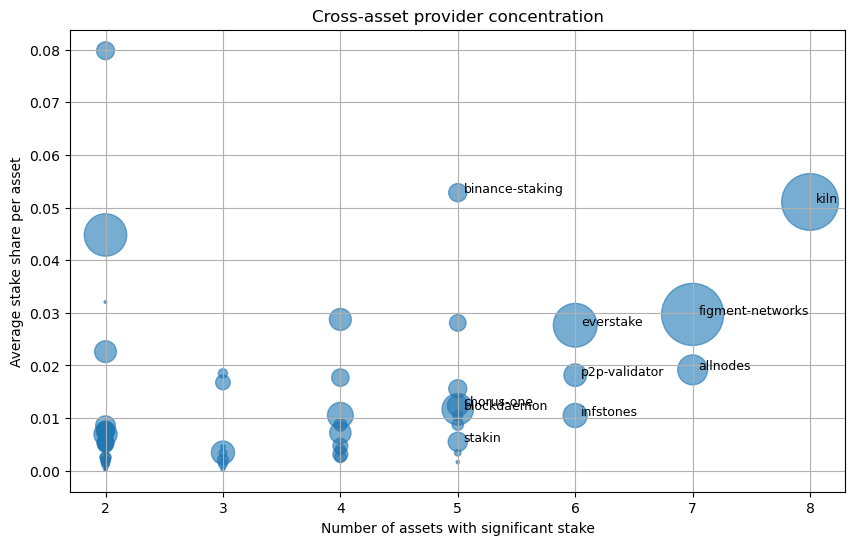

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(
    provider_cross["assets_present"],
    provider_cross["mean_asset_share"],
    s=provider_cross["total_effective_stake"] / provider_cross["total_effective_stake"].max() * 2000,
    alpha=0.6,
)

for _, row in provider_cross.head(10).iterrows():
    plt.text(
        row["assets_present"] + 0.05,
        row["mean_asset_share"],
        row["provider"],
        fontsize=9,
    )

plt.xlabel("Number of assets with significant stake")
plt.ylabel("Average stake share per asset")
plt.title("Cross-asset provider concentration")
plt.grid(True)
plt.show()


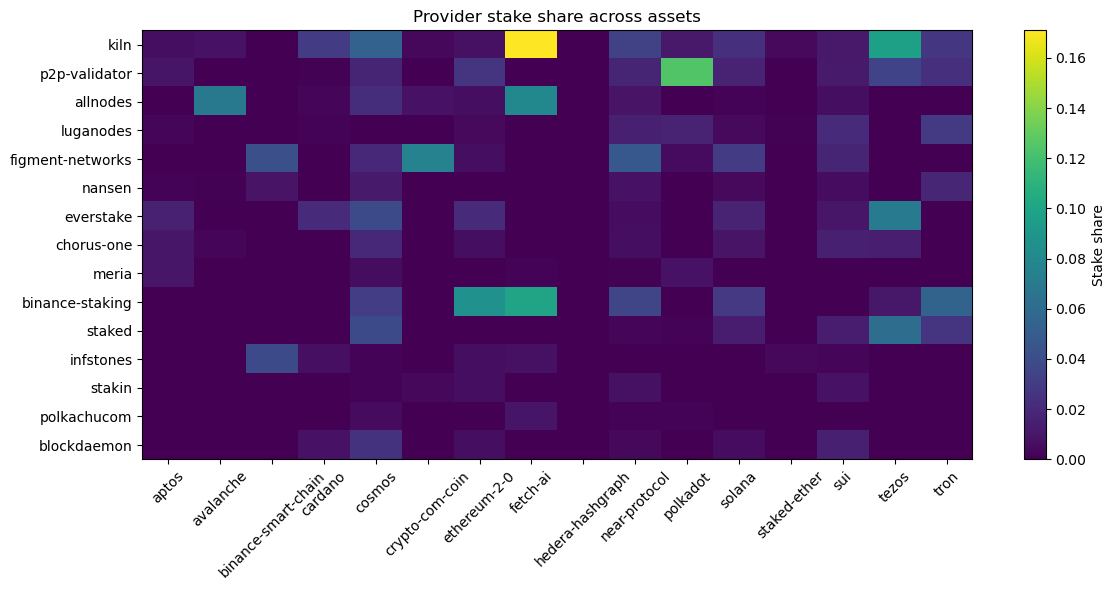

In [30]:
pivot = provider_asset_df.pivot_table(
    index="provider",
    columns="asset",
    values="stake_share_in_asset",
    aggfunc="max",
    fill_value=0.0,
)

# focus on top providers
top_providers = (
    provider_cross
    .head(15)["provider"]
)

pivot = pivot.loc[top_providers]

plt.figure(figsize=(12, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Stake share")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Provider stake share across assets")
plt.tight_layout()
plt.show()


In [19]:
resp = client.get_provider_stake_shares(
    asset_slug="ethereum-2-0",
    limit=300,
    is_active=True,
    include_reward_rate=True,   
)

providers = resp["providers"]
df = pd.DataFrame(providers)

pivot = (
    df.pivot_table(
        index="provider",
        columns="reward_option_type_key",
        values="staked_tokens",
        aggfunc="sum",
        fill_value=0.0,
    )
)

# Add total column
pivot["total_staked_tokens"] = pivot.sum(axis=1)

# Sort by total descending
pivot = pivot.sort_values("total_staked_tokens", ascending=False)

pivot

reward_option_type_key,actively-validated-service,hosting,lending,liquid-staking,operator,smart-contract,total_staked_tokens
provider,,,,,,,
velora,0.00,0.00,0.00,0.00,0.00,"32,484,682.85","32,484,682.85"
lido-finance,0.00,0.00,0.00,"9,576,492.23","2,530,816.00",0.00,"12,107,308.23"
ether-fi,0.00,0.00,0.00,"3,303,880.54","316,571.00",0.00,"3,620,451.54"
binance-staking,0.00,0.00,0.00,"3,174,428.05",0.00,0.00,"3,174,428.05"
kraken,0.00,0.00,0.00,0.00,"2,199,108.00",0.00,"2,199,108.00"
p2p-validator,0.00,"945,931.46",0.00,0.00,"229,097.14",0.00,"1,175,028.61"
everstake,0.00,"762,019.00",0.00,0.00,"263,616.00",0.00,"1,025,635.00"
stake-fish,0.00,"360,380.00",0.00,0.00,"404,482.00",0.00,"764,862.00"
pier-two,"1,583.23","55,317.00",0.00,0.00,"592,608.00",0.00,"649,508.23"


In [20]:
import matplotlib.pyplot as plt


def plot_lorenz_curve(
    providers: list[dict],
    total_value: float,
    residual_handling: str = "single",
    n_residual_providers: int | None = None,
    ax=None,
    title: str = "Lorenz curve",
):
    """
    Plot a Lorenz curve from absolute staking values.

    Args:
        providers: List of provider dicts
        total_value: Total staking amount for the network
        residual_handling:
            - "single": treat residual as one provider
            - "ignore": ignore residual entirely
            - "equal_split": split residual across n_residual_providers
        n_residual_providers: Number of hypothetical providers when using
            residual_handling="equal_split"
        ax: Optional matplotlib axes
        title: Plot title

    Returns:
        matplotlib Axes
    """
    if total_value <= 0:
        raise ValueError("total_value must be > 0")

    provider_value_key = "staked_tokens"

    values: list[float] = []
    tracked_total = 0.0

    for p in providers:
        value = p.get(provider_value_key)
        if value is None or value <= 0:
            continue
        values.append(float(value))
        tracked_total += value

    residual = total_value - tracked_total

    # ----------------------------------
    # Residual handling (same as Gini)
    # ----------------------------------
    if residual > 0:
        if residual_handling == "single":
            values.append(residual)

        elif residual_handling == "equal_split":
            if not n_residual_providers or n_residual_providers <= 0:
                raise ValueError(
                    "n_residual_providers must be > 0 when "
                    "residual_handling='equal_split'"
                )
            split_value = residual / n_residual_providers
            values.extend([split_value] * n_residual_providers)

        elif residual_handling == "ignore":
            pass

        else:
            raise ValueError(
                f"Unknown residual_handling mode: {residual_handling}"
            )

    if not values:
        raise ValueError("No positive staking values after residual handling")

    # ----------------------------------
    # Lorenz curve construction
    # ----------------------------------
    values.sort()
    n = len(values)
    total = sum(values)

    cumulative_value_share = [0.0]
    running = 0.0
    for v in values:
        running += v
        cumulative_value_share.append(running / total)

    cumulative_entity_share = [i / n for i in range(0, n + 1)]

    # ----------------------------------
    # Gini from Lorenz curve
    # ----------------------------------
    area = 0.0
    for i in range(1, len(cumulative_entity_share)):
        width = cumulative_entity_share[i] - cumulative_entity_share[i - 1]
        height = (
            cumulative_value_share[i] + cumulative_value_share[i - 1]
        ) / 2
        area += width * height

    gini = 1.0 - 2.0 * area
    gini = max(0.0, min(1.0, gini))  # numerical safety

    # ----------------------------------
    # Plotting
    # ----------------------------------
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    ax.plot(
        cumulative_entity_share,
        cumulative_value_share,
        label="Lorenz curve",
    )
    ax.plot([0, 1], [0, 1], "k--", label="Equality")
    ax.fill_between(
        cumulative_entity_share,
        cumulative_value_share,
        cumulative_entity_share,
        alpha=0.1,
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cumulative share of providers")
    ax.set_ylabel("Cumulative share of staked tokens")
    ax.set_title(title)
    ax.legend()
    ax.text(
        0.6,
        0.1,
        f"Gini: {gini:.3f}",
        transform=ax.transAxes,
    )

    return ax

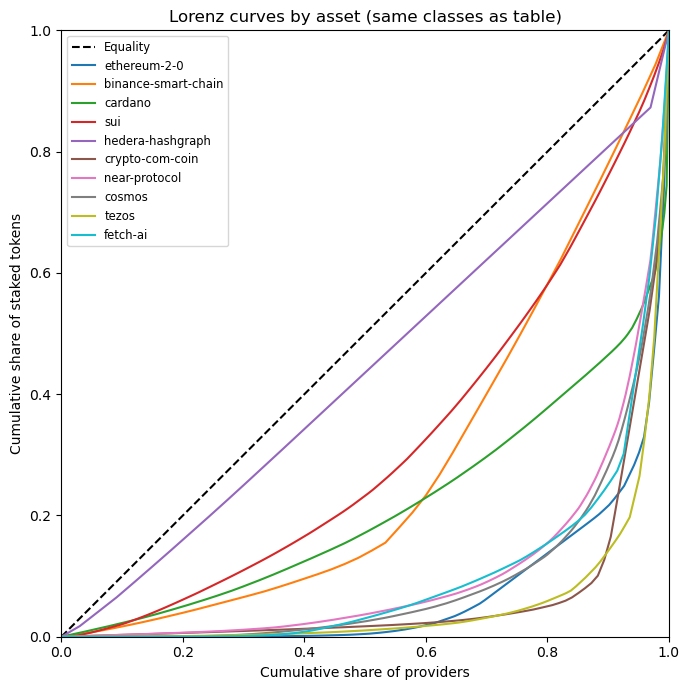

In [23]:
## Combined lorenz curve

def add_lorenz_curve_to_axis(
    ax,
    providers: list[dict],
    total_value: float,
    label: str,
    residual_handling: str = "single",
    n_residual_providers: int | None = None,
):
    provider_value_key = "staked_tokens"

    values = []
    tracked_total = 0.0

    for p in providers:
        v = p.get(provider_value_key)
        if v is None or v <= 0:
            continue
        values.append(float(v))
        tracked_total += v

    residual = total_value - tracked_total

    if residual > 0:
        if residual_handling == "single":
            values.append(residual)
        elif residual_handling == "equal_split":
            if not n_residual_providers or n_residual_providers <= 0:
                raise ValueError("n_residual_providers must be > 0")
            values.extend([residual / n_residual_providers] * n_residual_providers)
        elif residual_handling == "ignore":
            pass
        else:
            raise ValueError(f"Unknown residual_handling: {residual_handling}")

    if not values:
        return

    values.sort()
    n = len(values)
    total = sum(values)

    y = [0.0]
    running = 0.0
    for v in values:
        running += v
        y.append(running / total)

    x = [i / n for i in range(0, n + 1)]

    ax.plot(x, y, label=label)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

# equality line (draw once)
ax.plot([0, 1], [0, 1], "k--", label="Equality")

for asset in df["asset"]:
    data = lorenz_inputs.get(asset)
    if not data:
        continue

    add_lorenz_curve_to_axis(
        ax=ax,
        providers=data["providers"],
        total_value=data["total_value"],
        label=asset,
        residual_handling="single",   # MUST match table logic
    )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Cumulative share of providers")
ax.set_ylabel("Cumulative share of staked tokens")
ax.set_title("Lorenz curves by asset (same classes as table)")
ax.legend(loc="upper left", fontsize="small")

plt.tight_layout()
plt.show()

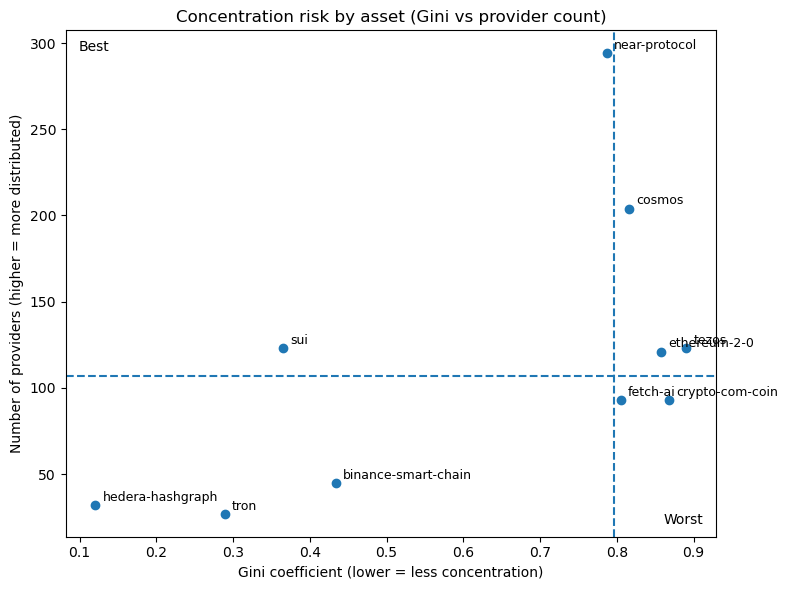

In [24]:
# Quadrant scatter plot
import matplotlib.pyplot as plt

MIN_COVERAGE_INCLUDED = 0.75
METRIC = "gini"

df_filtered = df[df["coverage_included"] >= MIN_COVERAGE_INCLUDED]

# choose quadrant split points
x_cut = df_filtered[METRIC].median()          # vertical line (gini)
y_cut = df_filtered["provider_count"].median() # horizontal line (providers)

fig, ax = plt.subplots(figsize=(8, 6))

# scatter
ax.scatter(df_filtered[METRIC], df_filtered["provider_count"])

# label points
for _, r in df_filtered.iterrows():
    ax.annotate(r["asset"], (r[METRIC], r["provider_count"]), xytext=(5, 3),
                textcoords="offset points", fontsize=9)

# quadrant lines
ax.axvline(x_cut, linestyle="--")
ax.axhline(y_cut, linestyle="--")

# axis labels / title
ax.set_xlabel("Gini coefficient (lower = less concentration)")
ax.set_ylabel("Number of providers (higher = more distributed)")
ax.set_title("Concentration risk by asset (Gini vs provider count)")

# optional: annotate quadrants
ax.text(0.02, 0.98, "Best", transform=ax.transAxes,
        va="top")
ax.text(0.98, 0.02, "Worst", transform=ax.transAxes,
        ha="right", va="bottom")

plt.tight_layout()
plt.show()

In [10]:
assets = [
    "ethereum-2-0",
    "binance-smart-chain",
    "solana",
    "cardano", 
    "waves", 
    "cosmos", 
    "avalanche", 
    "hyperliquid",
    "tron",
    "sui",
    "bittensor",
    "hedera-hashgraph",
    "aptos",
    "crypto-com-coin",
    "near-protocol",
    "story-network",
    "sei-network",
    "stacks",
    "tezos",
    "monad",
    "injective-protocol",
    "algorand",
    "celestia",
    "iota",
    "aleo",
    "fetch-ai",
    "starknet"
]

assets_on_rated = [
    "solana",
    "cardano",
    "celestia",
    "ethereum-2-0",
    "matic-network", # Polygon
    "avalanche",
    "polkadot,
    "cosmos",
    "eigenlayer",
    "babylon"
]

In [5]:
import math
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np

def _extract_points(stake_shares_response):
    """
    Extract (stake, reward_rate) pairs from get_provider_stake_shares response.

    Returns a list of (stake, reward_rate) tuples with both values present and > 0.
    """
    providers = stake_shares_response.get("providers") or []
    points = []
    for p in providers:
        stake = p.get("staked_tokens")
        rr = p.get("reward_rate")
        if stake is None or rr is None:
            continue
        try:
            stake_val = float(stake)
            rr_val = float(rr)
        except (TypeError, ValueError):
            continue
        if stake_val <= 0 or rr_val <= 0:
            continue
        points.append((stake_val, rr_val))
    return points

def plot_reward_rate_vs_stake(stake_shares_response, ax: Optional[plt.Axes] = None, title: Optional[str] = None, logx: bool = True, logy: bool = True):
    """
    Scatter + simple regression line for reward_rate vs staked_tokens.

    Args:
        stake_shares_response (dict): Response from get_provider_stake_shares
        ax (matplotlib.axes.Axes, optional): Axis to draw on; creates a new one if None.
        title (str, optional): Plot title.
        logx (bool, optional): Log scale for x (stake). Default True.
        logy (bool, optional): Log scale for y (reward rate). Default True.

    Returns:
        matplotlib.axes.Axes: The axis with the plot.

    Raises:
        ValueError: If fewer than two data points are available.
    """
    points = _extract_points(stake_shares_response)
    if len(points) < 2:
        raise ValueError("Need at least two providers with staked_tokens and reward_rate to plot regression.")

    stakes, reward_rates = zip(*points)
    stakes = np.array(stakes)
    reward_rates = np.array(reward_rates)

    ax = ax or plt.subplots(figsize=(7, 5))[1]
    ax.scatter(stakes, reward_rates, alpha=0.6, label="providers")

    # Regression on log-transformed data for robustness across magnitudes
    log_stakes = np.log(stakes)
    log_rr = np.log(reward_rates)
    slope, intercept = np.polyfit(log_stakes, log_rr, 1)
    fitted = np.exp(intercept) * stakes ** slope
    ax.plot(stakes, fitted, color="orange", label=f"fit: y = {math.exp(intercept):.3g} * x^{slope:.2f}")

    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    ax.set_xlabel("Staked tokens")
    ax.set_ylabel("Reward rate")
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.3)
    return ax


[4.953185270935226, 6.761219116716955, 5.128081087990655, 5.256890011279049, 5.550113603217018, 5.431166354749563, 4.24300561625051, 4.411465803506631, 5.003914779061452, 5.2012582753192005, 5.423108847985717, 5.09914598922659, 5.105361022081788, 6.338983941539193, 1.8889619184576987, 5.099970164425405, 5.593614233376213, 5.101823024693363, 5.100430465057795, 5.102958560636557, 4.535838127273348, 5.102154190077619, 5.624783903478171, 5.260890946450333, 5.1036233663927355, 5.4250281960920725, 5.540664518998523]


<Axes: title={'center': 'Provider staked token for avalanche'}, xlabel='Staked tokens', ylabel='Reward rate'>

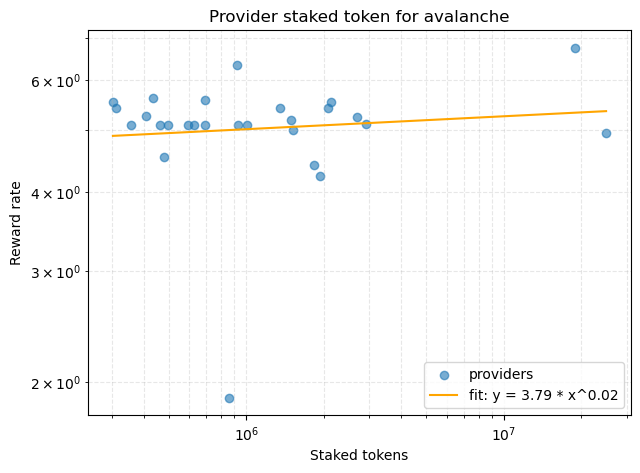

In [50]:
asset_slug=assets[6]
resp = client.get_provider_stake_shares(asset_slug=asset_slug, limit=200, is_active=True, include_reward_rate=True)
print([prov["reward_rate"] for prov in resp["providers"]])
plot_reward_rate_vs_stake(resp, title=f"Provider staked token for {asset_slug}")

In [10]:
import pandas as pd


def gini_from_stake_response(resp):
    """
    Compute Gini coefficient from get_provider_stake_shares response.
    Returns None if no staked token data is present.
    """
    providers = resp.get("providers") or []
    staked = [p.get("staked_tokens") for p in providers if p.get("staked_tokens") not in (None, 0)]
    if not staked:
        return None
    staked_sorted = sorted(staked)
    total = sum(staked_sorted)
    n = len(staked_sorted)
    if total == 0:
        return None
    area = 0.0
    running = 0.0
    for value in staked_sorted:
        prev = running / total
        running += value
        curr = running / total
        width = 1 / n
        area += width * (curr + prev) / 2
    return 1 - 2 * area


def weighted_average_reward_rate(providers):
    weighted_sum = 0.0
    total_weight = 0.0
    for p in providers:
        rr = p.get("reward_rate")
        stake = p.get("staked_tokens")
        if rr is None or stake in (None, 0):
            continue
        try:
            rr_val = float(rr)
            stake_val = float(stake)
        except (TypeError, ValueError):
            continue
        weighted_sum += rr_val * stake_val
        total_weight += stake_val
    if total_weight == 0:
        return None
    return weighted_sum / total_weight


rows = []
for asset_slug in assets:
    resp = client.get_provider_stake_shares(asset_slug=asset_slug, limit=200, is_active=True, include_reward_rate=True)
    providers = resp.get("providers") or []
    rows.append({
        "asset": asset_slug,
        "gini_coefficient": gini_from_stake_response(resp),
        "total_staked_tokens": resp.get("total_staked_tokens"),
        "uncovered_staking_part": resp.get("untracked_share"),
        "average_reward_rate": weighted_average_reward_rate(providers),
    })

summary_df = pd.DataFrame(rows)
summary_df

,asset,gini_coefficient,total_staked_tokens,uncovered_staking_part,average_reward_rate
0,ethereum-2-0,0.891494,3.569411e+07,NaN,3.876372
1,binance-smart-chain,0.412434,2.542967e+07,0.000000e+00,0.498212
2,solana,0.575564,4.138471e+08,5.730493e-01,6.352880
3,cardano,0.362558,2.101982e+10,3.556190e-01,2.376221
4,waves,0.761370,2.166231e+07,2.494765e-01,5.655753
5,cosmos,0.791212,2.854351e+08,NaN,16.924993
6,avalanche,0.676533,2.085705e+08,6.575791e-01,5.470428
7,hyperliquid,0.827883,4.311673e+08,NaN,2.153416
8,tron,0.287679,4.331291e+10,4.686949e-02,3.142734
9,sui,0.375899,7.478759e+09,NaN,1.833501


In [12]:
import json
import pandas as pd

# Set the asset slug to inspect
asset_slug = "avalanche"

# Provider stake + reward data
resp = client.get_provider_stake_shares(
    asset_slug=asset_slug,
    limit=200,
    is_active=True,
    include_reward_rate=True
)
providers = resp.get("providers") or []

# Fetch staking type information per provider
query = f"""
{{
  rewardOptions(
    where: {{ inputAsset: {{ slugs: [{json.dumps(asset_slug)}] }} }}
    limit: 200
    order: {{ metricKey_desc: "staked_tokens" }}
  ) {{
    providers(limit: 1) {{ slug name }}
    type {{ key label }}
  }}
}}
"""
type_result = client.execute_raw_query(query)
provider_types = {}
for ro in type_result.get("data", {}).get("rewardOptions", []) or []:
    prov = (ro.get("providers") or [{}])[0]
    slug = prov.get("slug")
    stake_type = None
    ro_type = ro.get("type")
    if ro_type:
        stake_type = ro_type.get("label") or ro_type.get("key")
    if slug and slug not in provider_types:
        provider_types[slug] = stake_type

# Build table
rows = []
for p in providers:
    slug = p.get("provider")
    rows.append({
        "provider": p.get("name") or slug,
        "staked_tokens": p.get("staked_tokens"),
        "percentage_of_total": (p.get("share") * 100) if p.get("share") is not None else None,
        "staking_type": provider_types.get(slug),
        "reward_rate": p.get("reward_rate"),
    })

df = pd.DataFrame(rows)
df = df.sort_values(by="percentage_of_total", ascending=False).reset_index(drop=True)
df

,provider,staked_tokens,percentage_of_total,staking_type,reward_rate
0,BENQI Liquid Staking,2.495062e+07,11.962683,liquid-staking,4.953185
1,Allnodes,1.892855e+07,9.075374,hosting,6.761219
2,GoGoPool,2.925044e+06,1.402425,liquid-staking,5.128081
3,091,2.700000e+06,1.294527,pos,5.256890
4,060,2.136406e+06,1.024309,pos,5.550114
5,059,2.078923e+06,0.996749,pos,5.431166
6,Kiln,1.937723e+06,0.929050,pos,4.243006
7,081,1.837000e+06,0.880758,pos,4.411466
8,085,1.512055e+06,0.724961,pos,5.003915
9,086,1.498000e+06,0.718223,pos,5.201258
